In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split, RandomizedSearchCV
%matplotlib inline

# Load the data

In [5]:
data = pd.read_csv('train.csv', index_col='id')

In [6]:
data.head()

,product_uid,product_title,search_term,relevance
id,,,,
2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [7]:
data.isnull().sum()

product_uid      0
product_title    0
search_term      0
relevance        0
dtype: int64

In [8]:
data.shape

(74067, 4)

In [9]:
desc = pd.read_csv('product_descriptions.csv')

In [10]:
desc.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [11]:
desc.isnull().sum()

product_uid            0
product_description    0
dtype: int64

In [12]:
# merge product description to main dataframe as features
df = pd.merge(left=data, right=desc, on='product_uid', how='left')

In [13]:
df.head()

,product_uid,product_title,search_term,relevance,product_description
0,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...


In [14]:
df.isnull().sum()

product_uid            0
product_title          0
search_term            0
relevance              0
product_description    0
dtype: int64

In [15]:
df.drop_duplicates().shape

11795

# Token Transformation

In [16]:
# define a function that accepts text and returns a list of lemmas
def split_into_lemmas(text):
    text = unicode(text, 'utf-8', errors='ignore').lower()
    words = TextBlob(text).words
    return [word.lemmatize() for word in words]

In [17]:
# Specify minimum frequency to reduce features. Tried ngram=(1,2), no difference
tvec = TfidfVectorizer(stop_words='english', strip_accents='unicode', decode_error='ignore', 
                       norm='l1', analyzer=split_into_lemmas, min_df=0.1)

In [18]:
# Transform product title into tokens
tvec.fit(df.product_title)
titles = pd.DataFrame(tvec.transform(df.product_title).todense(), columns = tvec.get_feature_names())
titles.shape

(74067, 6)

In [19]:
# Transform product description into tokens
tvec.fit(df.product_description)
descrip = pd.DataFrame(tvec.transform(df.product_description).todense(), columns = tvec.get_feature_names())
descrip.shape

(74067, 113)

In [20]:
# For search term, keep everything to match other features.
tvec_term = TfidfVectorizer(stop_words='english', strip_accents='unicode', decode_error='ignore', 
                       norm='l1', analyzer=split_into_lemmas)
tvec_term.fit(df.search_term)
terms = pd.DataFrame(tvec_term.transform(df.search_term).todense(), columns = tvec_term.get_feature_names())
terms.shape

(74067, 7658)

In [21]:
# Combine features together
features = pd.concat([titles, descrip, terms], axis=1)

In [22]:
features.head()

,and,ft,in,white,with,x,'s,1,2,3,...,zinsser,zip,zise,zone,zoned,zoom,zucchini,zurn,zwave,zymes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.062270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.062270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020752,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.038749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.038749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Models

In [23]:
X = features.values
y = df.relevance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

Features:  7777
r2:  0.167188923864
rmse:  0.487932993897


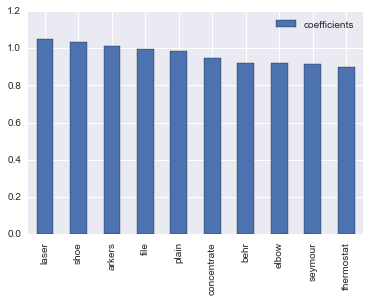

In [24]:
# Use bayesian ridge regression to fit the data and check matrices
br = BayesianRidge()
br.fit(X_train, y_train)
y_pred = br.predict(X_test)
coef = pd.DataFrame(br.coef_, index=features.columns, 
                    columns=['coefficients']).sort_values('coefficients', ascending=False)
print 'Features: ', X_train.shape[1]
print 'r2: ', metrics.r2_score(y_test, y_pred)
print 'rmse: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred))
coef.head(10).plot(kind='bar')

In [25]:
# rmse=0.48 compared to mean of 2.38
y.mean()

2.381633791027016

# Try cut search terms

In [30]:
tvec_term2 = TfidfVectorizer(stop_words='english', strip_accents='unicode', decode_error='ignore', 
                       norm='l1', analyzer=split_into_lemmas, min_df=2)
tvec_term2.fit(df.search_term)
terms2 = pd.DataFrame(tvec_term2.transform(df.search_term).todense(), columns = tvec_term2.get_feature_names())
terms2.shape

(74067, 6905)

In [31]:
features2 = pd.concat([titles, descrip, terms2], axis=1)

In [32]:
X = features2.values
y = df.relevance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [33]:
br.fit(X_train, y_train)
print 'rmse: ', np.sqrt(metrics.mean_squared_error(y_test, br.predict(X_test)))

rmse:  0.48830899954


# Try PCA

In [88]:
# try 100 principal components
pca = PCA(n_components=100)

In [89]:
# Transform features
X_pc = pca.fit_transform(X)

In [90]:
# Check the variance explained by principal components
pca.explained_variance_ratio_.sum()

0.55479489843160734

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_pc, y, test_size=0.3, random_state=7)

In [92]:
# Fit the model on components
br = BayesianRidge()
br.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [94]:
# Check the rmse
pc_pred = br.predict(X_test)
print 'rmse of pc: ', np.sqrt(metrics.mean_squared_error(y_test, pc_pred))

rmse of pc:  0.52819252535
